In [120]:
import logging

import numpy as np
from numba import njit

from shap import links
from shap.models import Model
from shap.utils import (
    MaskedModel,
    delta_minimization_order,
    make_masks,
    shapley_coefficients,
)
from shap.explainers._explainer import Explainer

log = logging.getLogger('shap')


class ExactExplainer(Explainer):
    """Computes SHAP values via an optimized exact enumeration.

    This works well for standard Shapley value maskers for models with less than ~15 features that vary
    from the background per sample. It also works well for Owen values from hclustering structured
    maskers when there are less than ~100 features that vary from the background per sample. This
    explainer minimizes the number of function evaluations needed by ordering the masking sets to
    minimize sequential differences. This is done using gray codes for standard Shapley values
    and a greedy sorting method for hclustering structured maskers.
    """

    def __init__(self, model, masker, link=links.identity, linearize_link=True, feature_names=None):
        """Build an explainers.Exact object for the given model using the given masker object.

        Parameters
        ----------
        model : function
            A callable python object that executes the model given a set of input data samples.

        masker : function or numpy.array or pandas.DataFrame
            A callable python object used to "mask" out hidden features of the form `masker(mask, *fargs)`.
            It takes a single a binary mask and an input sample and returns a matrix of masked samples. These
            masked samples are evaluated using the model function and the outputs are then averaged.
            As a shortcut for the standard masking used by SHAP you can pass a background data matrix
            instead of a function and that matrix will be used for masking. To use a clustering
            game structure you can pass a shap.maskers.TabularPartitions(data) object.

        link : function
            The link function used to map between the output units of the model and the SHAP value units. By
            default it is shap.links.identity, but shap.links.logit can be useful so that expectations are
            computed in probability units while explanations remain in the (more naturally additive) log-odds
            units. For more details on how link functions work see any overview of link functions for generalized
            linear models.

        linearize_link : bool
            If we use a non-linear link function to take expectations then models that are additive with respect to that
            link function for a single background sample will no longer be additive when using a background masker with
            many samples. This for example means that a linear logistic regression model would have interaction effects
            that arise from the non-linear changes in expectation averaging. To retain the additively of the model with
            still respecting the link function we linearize the link function by default.

        """ # TODO link to the link linearization paper when done
        super().__init__(model, masker, link=link, linearize_link=linearize_link, feature_names=feature_names)

        self.model = Model(model)

        if getattr(masker, "clustering", None) is not None:
            self._partition_masks, self._partition_masks_inds = partition_masks(masker.clustering)
            self._partition_delta_indexes = partition_delta_indexes(masker.clustering, self._partition_masks)

        self._gray_code_cache = {} # used to avoid regenerating the same gray code patterns

    def __call__(self, *args, max_evals=100000, main_effects=False, error_bounds=False, batch_size="auto", interactions=1, silent=False):
        """Explains the output of model(*args), where args represents one or more parallel iterators."""
        # we entirely rely on the general call implementation, we override just to remove **kwargs
        # from the function signature
        return super().__call__(
            *args, max_evals=max_evals, main_effects=main_effects, error_bounds=error_bounds,
            batch_size=batch_size, interactions=interactions, silent=silent
        )

    def _cached_gray_codes(self, n):
        if n not in self._gray_code_cache:
            self._gray_code_cache[n] = gray_code_indexes(n)
        return self._gray_code_cache[n]

    def explain_row(self, *row_args, max_evals, main_effects, error_bounds, batch_size, outputs, interactions, silent):
        """Explains a single row and returns the tuple (row_values, row_expected_values, row_mask_shapes)."""
        # build a masked version of the model for the current input sample
        fm = MaskedModel(self.model, self.masker, self.link, self.linearize_link, *row_args)

        # do the standard Shapley values
        inds = None
        if getattr(self.masker, "clustering", None) is None:

            # see which elements we actually need to perturb
            inds = fm.varying_inputs()

            # make sure we have enough evals
            if max_evals is not None and max_evals != "auto" and max_evals < 2**len(inds):
                raise ValueError(
                    f"It takes {2**len(inds)} masked evaluations to run the Exact explainer on this instance, but max_evals={max_evals}!"
                )

            # generate the masks in gray code order (so that we change the inputs as little
            # as possible while we iterate to minimize the need to re-eval when the inputs
            # don't vary from the background)
            delta_indexes = self._cached_gray_codes(len(inds))

            # map to a larger mask that includes the invariant entries
            extended_delta_indexes = np.zeros(2**len(inds), dtype=int)
            for i in range(2**len(inds)):
                if delta_indexes[i] == MaskedModel.delta_mask_noop_value:
                    extended_delta_indexes[i] = delta_indexes[i]
                else:
                    extended_delta_indexes[i] = inds[delta_indexes[i]]

            # run the model
            outputs = fm(extended_delta_indexes, zero_index=0, batch_size=batch_size)

            # Shapley values
            # Care: Need to distinguish between `True` and `1`
            if interactions is False or (interactions == 1 and interactions is not True):

                # loop over all the outputs to update the rows
                coeff = shapley_coefficients(len(inds))
                row_values = np.zeros((len(fm),) + outputs.shape[1:])
                mask = np.zeros(len(fm), dtype=bool)
                _compute_grey_code_row_values(row_values, mask, inds, outputs, coeff, extended_delta_indexes, MaskedModel.delta_mask_noop_value)

            # Shapley-Taylor interaction values
            elif interactions is True or interactions == 2:

                # loop over all the outputs to update the rows
                coeff = shapley_coefficients(len(inds))
                row_values = np.zeros((len(fm), len(fm)) + outputs.shape[1:])
                mask = np.zeros(len(fm), dtype=bool)
                _compute_grey_code_row_values_st(row_values, mask, inds, outputs, coeff, extended_delta_indexes, MaskedModel.delta_mask_noop_value)

            elif interactions > 2:
                raise NotImplementedError("Currently the Exact explainer does not support interactions higher than order 2!")

        # do a partition tree constrained version of Shapley values
        else:

            # make sure we have enough evals
            if max_evals is not None and max_evals != "auto" and max_evals < len(fm)**2:
                raise ValueError(
                    f"It takes {len(fm)**2} masked evaluations to run the Exact explainer on this instance, but max_evals={max_evals}!"
                )

            # generate the masks in a hclust order (so that we change the inputs as little
            # as possible while we iterate to minimize the need to re-eval when the inputs
            # don't vary from the background)
            delta_indexes = self._partition_delta_indexes

            # run the model
            print(delta_indexes)
            outputs = fm(delta_indexes, batch_size=batch_size)

            # loop over each output feature
            row_values = np.zeros((len(fm),) + outputs.shape[1:])
            for i in range(len(fm)):
                on_outputs = outputs[self._partition_masks_inds[i][1]]
                off_outputs = outputs[self._partition_masks_inds[i][0]]
                row_values[i] = (on_outputs - off_outputs).mean(0)

        # compute the main effects if we need to
        main_effect_values = None
        if main_effects or interactions is True or interactions == 2:
            if inds is None:
                inds = np.arange(len(fm))
            main_effect_values = fm.main_effects(inds)
            if interactions is True or interactions == 2:
                for i in range(len(fm)):
                    row_values[i, i] = main_effect_values[i]

        return {
            "values": row_values,
            "expected_values": outputs[0],
            "mask_shapes": fm.mask_shapes,
            "main_effects": main_effect_values if main_effects else None,
            "clustering": getattr(self.masker, "clustering", None)
        }

@njit
def _compute_grey_code_row_values(row_values, mask, inds, outputs, shapley_coeff, extended_delta_indexes, noop_code):
    set_size = 0
    M = len(inds)
    for i in range(2**M):

        # update the mask
        delta_ind = extended_delta_indexes[i]
        if delta_ind != noop_code:
            mask[delta_ind] = ~mask[delta_ind]
            if mask[delta_ind]:
                set_size += 1
            else:
                set_size -= 1

        # update the output row values
        on_coeff = shapley_coeff[set_size-1]
        if set_size < M:
            off_coeff = shapley_coeff[set_size]
        out = outputs[i]
        for j in inds:
            if mask[j]:
                row_values[j] += out * on_coeff
            else:
                row_values[j] -= out * off_coeff

@njit
def _compute_grey_code_row_values_st(row_values, mask, inds, outputs, shapley_coeff, extended_delta_indexes, noop_code):
    set_size = 0
    M = len(inds)
    for i in range(2**M):

        # update the mask
        delta_ind = extended_delta_indexes[i]
        if delta_ind != noop_code:
            mask[delta_ind] = ~mask[delta_ind]
            if mask[delta_ind]:
                set_size += 1
            else:
                set_size -= 1

        # distribute the effect of this mask set over all the terms it impacts
        out = outputs[i]
        for j in range(M):
            for k in range(j+1, M):
                if not mask[j] and not mask[k]:
                    delta = out * shapley_coeff[set_size] # * 2
                elif (not mask[j] and mask[k]) or (mask[j] and not mask[k]):
                    delta = -out * shapley_coeff[set_size - 1] # * 2
                else: # both true
                    delta = out * shapley_coeff[set_size - 2] # * 2
                row_values[j,k] += delta
                row_values[k,j] += delta

def partition_delta_indexes(partition_tree, all_masks):
    """Return an delta index encoded array of all the masks possible while following the given partition tree."""
    # convert the masks to delta index format
    mask = np.zeros(all_masks.shape[1], dtype=bool)
    delta_inds = []
    for i in range(len(all_masks)):
        inds = np.where(mask ^ all_masks[i,:])[0]
        print(inds)

        for j in inds[:-1]:
            delta_inds.append(-j - 1) # negative + (-1) means we have more inds still to change...
        if len(inds) == 0:
            delta_inds.append(MaskedModel.delta_mask_noop_value)
        else:
            delta_inds.extend(inds[-1:])
        mask = all_masks[i,:]
        #print(delta_inds)

    return np.array(delta_inds)

def partition_masks(partition_tree):
    """Return an array of all the masks possible while following the given partition tree."""
    M = partition_tree.shape[0] + 1
    mask_matrix = make_masks(partition_tree)
    all_masks = []
    m00 = np.zeros(M, dtype=bool)
    all_masks.append(m00)
    all_masks.append(~m00)
    #inds_stack = [0,1]
    inds_lists = [[[], []] for i in range(M)]
    _partition_masks_recurse(len(partition_tree)-1, m00, 0, 1, inds_lists, mask_matrix, partition_tree, M, all_masks)

    all_masks = np.array(all_masks)

    # we resort the clustering matrix to minimize the sequential difference between the masks
    # this minimizes the number of model evaluations we need to run when the background sometimes
    # matches the foreground. We seem to average about 1.5 feature changes per mask with this
    # approach. This is not as clean as the grey code ordering, but a perfect 1 feature change
    # ordering is not possible with a clustering tree
    order = delta_minimization_order(all_masks)
    inverse_order = np.arange(len(order))[np.argsort(order)]

    for inds_list0,inds_list1 in inds_lists:
        for i in range(len(inds_list0)):
            inds_list0[i] = inverse_order[inds_list0[i]]
            inds_list1[i] = inverse_order[inds_list1[i]]

    # Care: inds_lists have different lengths, so partition_masks_inds is a "ragged" array. See GH #3063
    partition_masks = all_masks[order]
    partition_masks_inds = [[np.array(on), np.array(off)] for on, off in inds_lists]
    return partition_masks, partition_masks_inds

# TODO: this should be a jit function... which would require preallocating the inds_lists (sizes are 2**depth of that ind)
# TODO: we could also probable avoid making the masks at all and just record the deltas if we want...
def _partition_masks_recurse(index, m00, ind00, ind11, inds_lists, mask_matrix, partition_tree, M, all_masks):
    if index < 0:
        inds_lists[index + M][0].append(ind00)
        inds_lists[index + M][1].append(ind11)
        return

    # get our children indexes
    left_index = int(partition_tree[index,0] - M)
    right_index = int(partition_tree[index,1] - M)

    # build more refined masks
    print(m00)
    m10 = m00.copy() # we separate the copy from the add so as to not get converted to a matrix
    #print(left_index+M)
    m10[:] += mask_matrix[left_index+M, :]
    print(m10)
    m01 = m00.copy()
    #print(right_index+M)
    m01[:] += mask_matrix[right_index+M, :]

    # record the new masks we made
    
    ind01 = len(all_masks)
    print(ind01)
    all_masks.append(m01)
    
    ind10 = len(all_masks)
    print(ind10)
    all_masks.append(m10)

    # inds_stack.append(len(all_masks) - 2)
    # inds_stack.append(len(all_masks) - 1)

    # recurse left and right with both 1 (True) and 0 (False) contexts
    #print(left_index, m00, ind00, ind10, inds_lists, mask_matrix, partition_tree, M, all_masks)
    _partition_masks_recurse(left_index, m00, ind00, ind10, inds_lists, mask_matrix, partition_tree, M, all_masks)
    _partition_masks_recurse(right_index, m10, ind10, ind11, inds_lists, mask_matrix, partition_tree, M, all_masks)
    _partition_masks_recurse(left_index, m01, ind01, ind11, inds_lists, mask_matrix, partition_tree, M, all_masks)
    _partition_masks_recurse(right_index, m00, ind00, ind01, inds_lists, mask_matrix, partition_tree, M, all_masks)


def gray_code_masks(nbits):
    """Produces an array of all binary patterns of size nbits in gray code order.

    This is based on code from: http://code.activestate.com/recipes/576592-gray-code-generatoriterator/
    """
    out = np.zeros((2**nbits, nbits), dtype=bool)
    li = np.zeros(nbits, dtype=bool)

    for term in range(2, (1<<nbits)+1):
        if term % 2 == 1: # odd
            for i in range(-1,-nbits,-1):
                if li[i] == 1:
                    li[i-1] = li[i-1]^1
                    break
        else: # even
            li[-1] = li[-1]^1

        out[term-1,:] = li
    return out

def gray_code_indexes(nbits):
    """Produces an array of which bits flip at which position.

    We assume the masks start at all zero and -1 means don't do a flip.
    This is a more efficient representation of the gray_code_masks version.
    """
    out = np.ones(2**nbits, dtype=int) * MaskedModel.delta_mask_noop_value
    li = np.zeros(nbits, dtype=bool)
    for term in range((1<<nbits)-1):
        if term % 2 == 1: # odd
            for i in range(-1,-nbits,-1):
                if li[i] == 1:
                    li[i-1] = li[i-1]^1
                    out[term+1] = nbits + (i-1)
                    break
        else: # even
            li[-1] = li[-1]^1
            out[term+1] = nbits-1
    return out


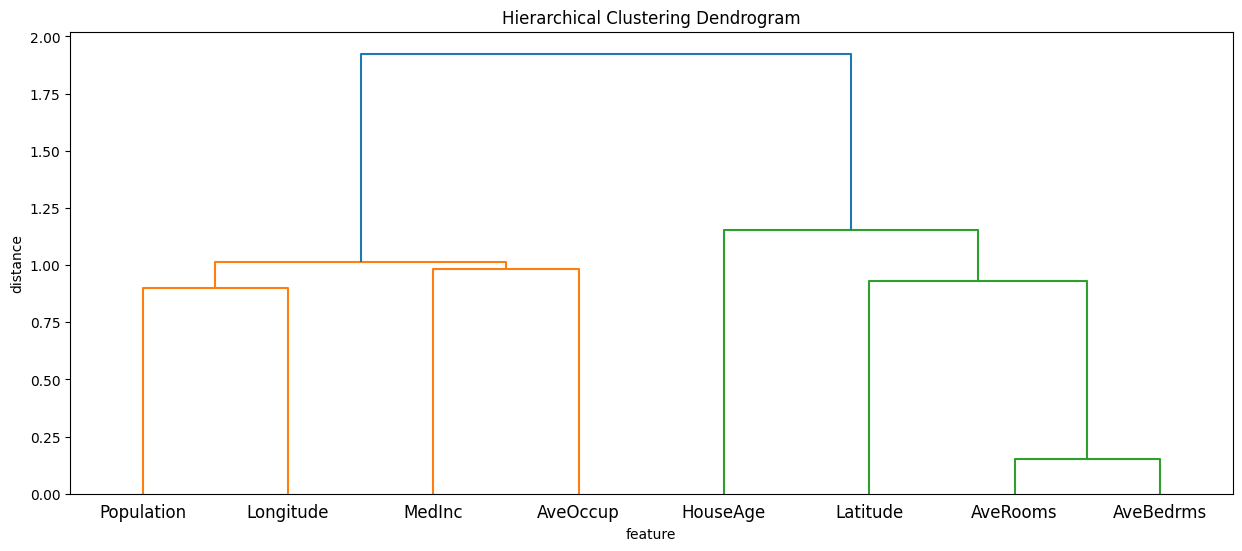

In [122]:

import matplotlib.pyplot as plt

import numpy as np

import scipy as sp

import scipy.cluster

from xgboost import XGBRegressor

import time


import shap

from numba import njit


seed = 2023

np.random.seed(seed)

X, y = shap.datasets.california()

model = XGBRegressor(n_estimators=100, subsample=0.3)

model.fit(X, y)

instance = X[0:1]

references = X[1:100]

def partition_tree(X, metric="correlation"):

    X_full_rank = X + np.random.randn(*X.shape) * 1e-8

    D = scipy.spatial.distance.pdist(

        X_full_rank.fillna(X_full_rank.mean()).T, metric=metric

    )

    return scipy.cluster.hierarchy.complete(D)

partition_tree = shap.utils.partition_tree(X)

plt.figure(figsize=(15, 6))

sp.cluster.hierarchy.dendrogram(partition_tree, labels=X.columns)

plt.title("Hierarchical Clustering Dendrogram")

plt.xlabel("feature")

plt.ylabel("distance")

plt.show()

In [123]:
# build a masker from partition tree, this masker object is what I am aiming to rewrite to respect any arbitrary hierarchy 
masker = shap.maskers.Partition(X, clustering=partition_tree)
# build explainer objects

exact_explainer = ExactExplainer(model.predict, masker)
partition_explainer = shap.PartitionExplainer(model.predict, masker)

exact_start=time.time()
exact_shap_values = exact_explainer(instance)
print("exact method time: ", time.time()-exact_start)

partition_start=time.time()
partition_shap_values = partition_explainer(instance)
print("partition method time: ", time.time()-partition_start)


[False False False False False False False False]
[ True False False False  True  True False  True]
2
3
[False False False False False False False False]
[False False False False  True False False  True]
4
5
[False False False False False False False False]
[False False False False  True False False False]
6
7
[False False False False  True False False  True]
[ True False False False  True False False  True]
8
9
[ True False False False False  True False False]
[ True False False False  True  True False False]
10
11
[False False False False False False False False]
[ True False False False False False False False]
12
13
[ True False False False  True  True False  True]
[ True  True False False  True  True False  True]
14
15
[ True  True False False  True  True False  True]
[ True  True False False  True  True  True  True]
16
17
[ True  True False False  True  True  True  True]
[ True  True  True False  True  True  True  True]
18
19
[ True  True False False  True  True False  True]
[ Tr

In [126]:
exact_explainer(instance)

[2147483647         -2          2          2          6          2
         -3          3          6          2          6          4
         -6          7          0          3          6          2
         -2          7         -1          4         -1          5
          5          7         -1          5          4          7
         -6          7         -1          5          5         -2
          6          3         -2          2          6          3
          6          2          3          6          1          2
         -6          6          0          4         -1          5
          7          4         -1          4         -1          5
         -1          1          6          2          6          3
          2          6]


.values =
array([[ 1.48833262,  0.06782281,  0.60202918,  0.00896832, -0.08800008,
         0.09939416, -0.62810122,  0.91961976]])

.base_values =
array([1.96104483])

.data =
array([[   8.3252    ,   41.        ,    6.98412698,    1.02380952,
         322.        ,    2.55555556,   37.88      , -122.23      ]])